# Draw the Plot Comparing loss with Feyman-Kac Loss

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, vmap
from time import time

import math, os, sys
torch.manual_seed(0)

# dimension
D = 100

# domain width
L = 1.0

# rhs

om = 2.

c = -1.


def f(x):
    return (-om ** 2 + c) * (om * x).cos().sum()


# boundary condition
def g(x):
    return (om * x).cos().sum()


def u_true(x):
    return (om * x).cos().sum()


# path simulation time
T = .25 / np.sqrt(D)

# Total umber of paths
M_tot = 100000

# Batch size of each epoch
M = 5000

# number of grid points
N = 5

# number of grid points at the boundaries
N_bdry = 100000

# weight of boundary loss
c_boundary = 1.0

# number of collocation points for evaluating the integral
N_test = 10000

# number of training epochs
n_epoch = 10000

# time step size
dt = T / N
dBt = math.sqrt(dt)

def sample_NDstdBM_paths(M: int, D: int, T: float, N: int):
    return torch.cumsum(
        torch.concat([
            torch.zeros(M, 1, D),
            torch.randn(M, N, D) * math.sqrt(T / N)
        ], dim=1), dim=1
    )

def sample_boundary_points(N_bdry: int, D: int, L: float):
    rand_n = torch.randn(N_bdry, D)
    return rand_n / rand_n.square().sum(dim=1).sqrt().unsqueeze(dim=1) * L


X_bdry = sample_boundary_points(N_bdry, D, L)


W_tot = sample_NDstdBM_paths(M_tot, D, T, N)

u = nn.Sequential(nn.Linear(D, 128),
                  nn.Tanh(), # nn.GELU(approximate="tanh"),
                  nn.Linear(128, 32),
                  nn.GELU(approximate="tanh"),
                  nn.Linear(32, 1))

X_test = torch.randn(N_test, D)
X_test = X_test / X_test.norm(dim=1).unsqueeze(dim=1) * torch.rand(N_test, 1) * L

optimizer = torch.optim.Adamax(u.parameters(), lr=.05, )

loss_rec = np.zeros(n_epoch + 1)
l2_err_rec = np.zeros(n_epoch + 1)
l2_norm_rec = np.zeros(n_epoch + 1)

f_val_tot = vmap(vmap(f))(W_tot)
g_val = vmap(g)(X_bdry)

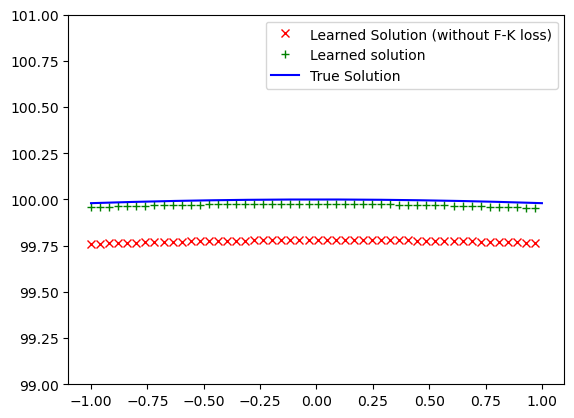

In [33]:
u.load_state_dict(torch.load("the_network.pt"))

x_test = torch.linspace(-L / np.sqrt(D), L / np.sqrt(D), 200).unsqueeze(dim=1) * torch.tensor([L / np.sqrt(D)] * D).type(torch.float)
plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "rx")

u.load_state_dict(torch.load("old_result_with_FK/the_network.pt"))
plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "g+")

plt.plot(np.linspace(-L, L, 200), vmap(u_true)(x_test).detach().numpy(), "b")
plt.ylim(99, 101)
plt.legend(["Learned Solution (without F-K loss)", "Learned solution", "True Solution"])
plt.savefig("100d_diag.png")
plt.show()

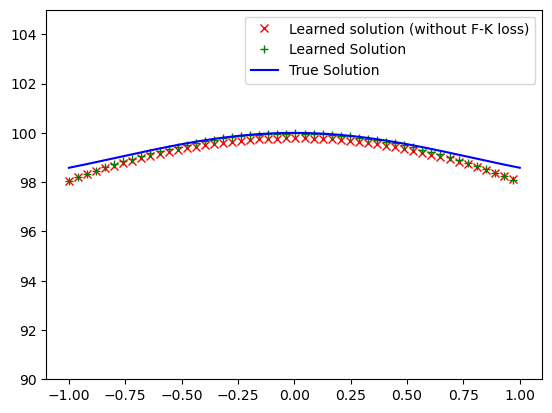

In [34]:
u.load_state_dict(torch.load("the_network.pt"))

x_test = torch.linspace(-1, 1, 200).unsqueeze(dim=1) * (torch.tensor([1.] + [0.] * (D-1)))

plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "rx")

u.load_state_dict(torch.load("old_result_with_FK/the_network.pt"))
plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "g+")

plt.plot(np.linspace(-L, L, 200), vmap(u_true)(x_test).detach().numpy(), "b")
plt.ylim(90, 105)
plt.legend(["Learned solution (without F-K loss)", "Learned Solution", "True Solution"])
plt.savefig("100d_axis.png")
plt.show()

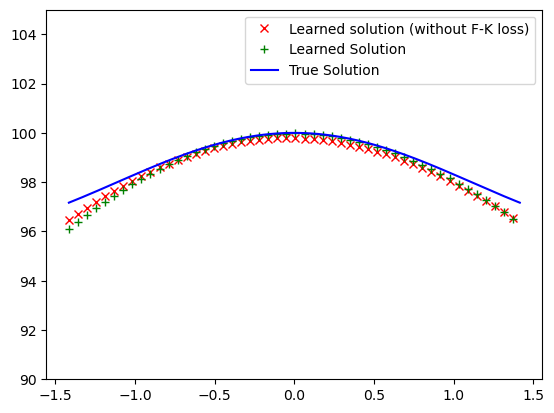

In [35]:
u.load_state_dict(torch.load("the_network.pt"))

x_test = torch.linspace(-1, 1, 200).unsqueeze(dim=1) * (torch.tensor([1., 1.] + [0.] * (D-2)))

plt.plot(np.linspace(-L, L, 200)[::4] * np.sqrt(2), u(x_test).squeeze().detach().numpy()[::4], "rx")

u.load_state_dict(torch.load("old_result_with_FK/the_network.pt"))
plt.plot(np.linspace(-L, L, 200)[::4] * np.sqrt(2), u(x_test).squeeze().detach().numpy()[::4], "g+")

plt.plot(np.linspace(-L, L, 200) * np.sqrt(2), vmap(u_true)(x_test).detach().numpy(), "b")
plt.ylim(90, 105)
plt.legend(["Learned solution (without F-K loss)", "Learned Solution", "True Solution"])
plt.savefig("100d_diag2.png")
plt.show()

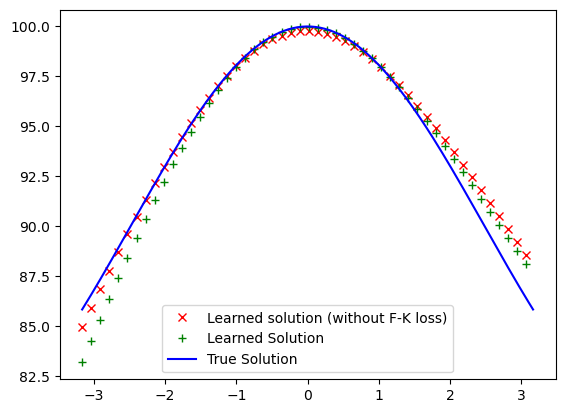

In [36]:
u.load_state_dict(torch.load("the_network.pt"))
x_test = torch.linspace(-1, 1, 200).unsqueeze(dim=1) * (torch.tensor([1.] * 10 + [0.] * (D-10)))

plt.plot(np.linspace(-L, L, 200)[::4] * np.sqrt(10), u(x_test).squeeze().detach().numpy()[::4], "rx")

u.load_state_dict(torch.load("old_result_with_FK/the_network.pt"))
plt.plot(np.linspace(-L, L, 200)[::4] * np.sqrt(10), u(x_test).squeeze().detach().numpy()[::4], "g+")
plt.plot(np.linspace(-L, L, 200) * np.sqrt(10), vmap(u_true)(x_test).detach().numpy(), "b")

# plt.ylim(90, 105)
plt.legend(["Learned solution (without F-K loss)", "Learned Solution", "True Solution"])
plt.savefig("100d_diag10.png")
plt.show()

In [ ]:
rec = np.load("loss_and_err.npz")
l2_err_rec = rec["l2_err_rec"]
loss_rec = rec["loss_rec"]

plt.semilogy(loss_rec[2:-1])
plt.title("loss")
plt.show()

plt.semilogy(loss_rec[2:-1])
plt.title("loss")
plt.show()